In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pylab as plt
import h5py
from tqdm.notebook import tqdm

from scipy import ndimage as ndi
from scipy.ndimage.morphology import (distance_transform_edt, binary_fill_holes,
                binary_closing, binary_opening, binary_dilation, binary_erosion)
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.segmentation import watershed, random_walker
from skimage.morphology import disk, ball
from pathlib import Path
import cv2

In [3]:
data_folderes = ['/diskmnt/b/makov/robotom/74f73e80-3048-4b86-b67b-80b7d631bb85',]

In [4]:
df_number = 0
df = Path(data_folderes[df_number]).glob('tomo_rec.*.h5')
df=list(df)[0]
data = h5py.File(df, 'r')['Reconstruction']
data = data[20:-5, 510:1190, 400:1060]
# if df_number == 0 :
#     data = data[210:,300:1000, 200:900]
# elif df_number == 1 :
#     data = data[1850:2400, 400:1600, 400:1700]
# elif df_number ==2:
#     data = data[1790:2320, 580:1300, 500:1260]

In [5]:
# plt.figure()
# plt.imshow(data[20: -5,500:1200, 400:1060])
# plt.show()

In [6]:
def create_mask(img):
    thrs1 = np.percentile(img.flat[::100], 80)   
    thrs2 = np.percentile(img.flat[::100], 10)  
    
    need_squeeze = False
    if img.ndim == 2:
        need_squeeze = True
        img = img[np.newaxis,:,:]
    
#     markers = np.zeros_like(img, dtype=np.uint16)
#     markers[img > thrs1] = 1
#     markers[img < thrs2] = 2
#     t = random_walker(img.astype(np.float32), markers, 1)
    tt = np.zeros((3,img.shape[0],img.shape[1], img.shape[2]), dtype=np.uint16)
    for j in range(3):
        t = np.zeros_like(img, dtype=np.uint16)
        for i in tqdm(range(t.shape[j])):
            t_img = img.take(i,j)
            markers = np.zeros_like(t_img, dtype=np.uint16)
            markers[t_img > thrs1] = 1
            markers[t_img < thrs2] = 2
            rt = random_walker(t_img, markers, beta=1)
            if j==0:
                t[i] = rt
            elif j==1:
                t[:,i,:] = rt
            elif j==2:
                t[:,:,i] = rt
                
        if need_squeeze:
            t = np.squeeze(t)
            
        tt[j]=t
    return tt      

In [7]:
sample = data#[data.shape[0]//2-50:data.shape[0]//2+50]
mask_vanila = create_mask(sample)-1

In [8]:
mask_mean = np.median(mask_vanila, axis=0)

In [9]:
# sample = data
# mask_vanila = create_mask(sample)-1
mask_no_stones = binary_closing(mask_mean, ball(2),border_value=1)
mask_border = 1-binary_opening(mask_no_stones, ball(5))
mask_no_holes = binary_closing(mask_border, ball(3), iterations=5)
mask_no_holes = binary_fill_holes(mask_no_holes)
mask_no_holes = binary_erosion(mask_no_holes, ball(3))
# mask_no_holes = binary_opening(mask_t,ball(3),border_value=1)
# mask_no_stones = np.zeros_like(mask_vanila)
# mask_border = np.zeros_like(mask_vanila)
# mask_no_holes = np.zeros_like(mask_vanila)
# for i in tqdm(range(mask.shape[0])):
#     mask_no_stones[i] = binary_closing(mask_vanila[i], disk(2))
#     mask_border[i] = 1-binary_opening(mask_no_stones[i], disk(5))
#     mask_no_holes[i] = binary_opening(1-binary_fill_holes(mask_border[i], disk(5)),disk(5),border_value=1)

In [10]:
# plt.figure(figsize=(15,15))
# plt.imshow(mask_mean[10], vmin=0.01,vmax=0.2, cmap=plt.cm.gray_r)
# # plt.contour(mask_vanila, colors='r', linewidths=0.1)
# # plt.contour(mask_no_stones, colors='b', linewidths=0.3)
# # plt.contour(mask_vanila*(1-mask_no_holes), colors='g', linewidths=0.5)
# # plt.imshow(mask_no_holes, cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')
# plt.show()

In [11]:
pores = mask_no_stones*mask_no_holes
borders = (1-pores)*mask_no_holes

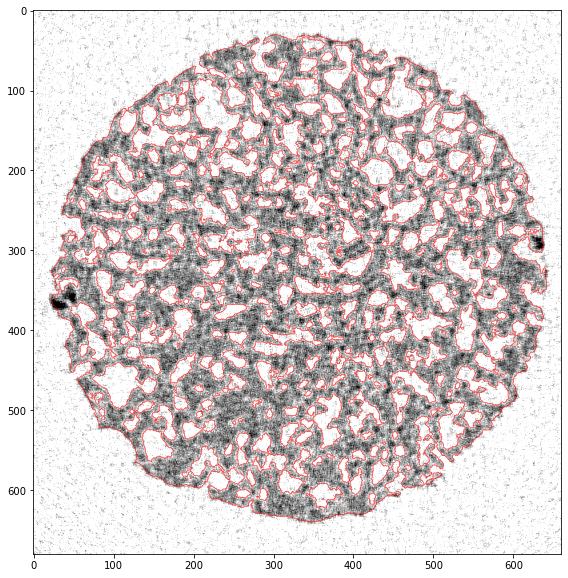

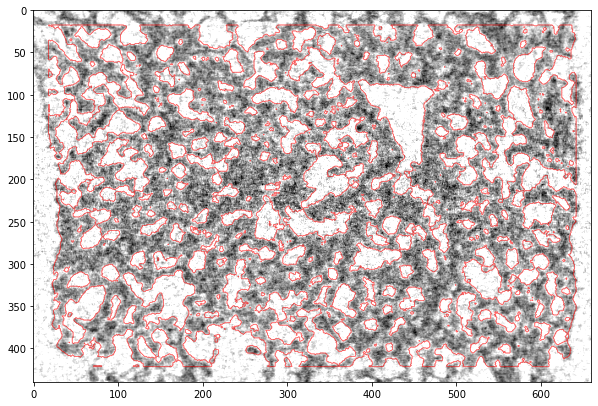

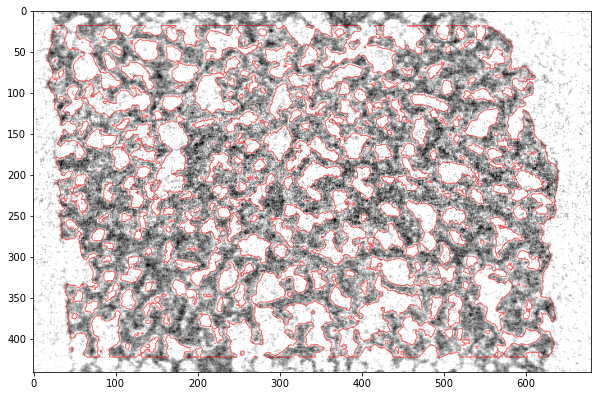

In [12]:
for i in range(3):
    plt.figure(figsize=(10,10))
    plt.imshow(sample.take(sample.shape[i]//2, i),
               vmin=0.01,vmax=0.2, cmap=plt.cm.gray_r)
#     plt.imshow(mask_no_stones.take(sample.shape[i]//2, i)*(1-mask_no_holes.take(sample.shape[i]//2, i)),
#                 cmap=plt.cm.gray)
#     plt.colorbar(orientation='horizontal')
    plt.contour((borders.take(sample.shape[i]//2, i)), colors='r', linewidths=0.1)
    plt.show()

In [13]:
# !rm -rf images

In [14]:
# out_dir = Path('pores')/str(df_number)
# out_dir.mkdir(parents=True, exist_ok=True)

In [15]:
# for i in tqdm_notebook(range(data.shape[0])):
#     plt.imsave(out_dir / f'0_{i}.png',data[i], vmin=0.01, vmax=0.1, cmap=plt.cm.gray_r)

# for i in tqdm_notebook(range(data.shape[1])):
#     plt.imsave(out_dir / f'1_{i}.png',data[:,i,:], vmin=0.01, vmax=0.1, cmap=plt.cm.gray_r)

# for i in tqdm_notebook(range(data.shape[2])):
#     plt.imsave(out_dir / f'2_{i}.png',data[:,:,i], vmin=0.01, vmax=0.1, cmap=plt.cm.gray_r)

In [16]:
# !ffmpeg -y -r 10 -i "{out_dir}/0_%d.png" -b:v 2000k {out_dir}/poly_0.avi
# !ffmpeg -y -r 10 -i "{out_dir}/1_%d.png" -b:v 2000k {out_dir}/poly_1.avi
# !ffmpeg -y -r 10 -i "{out_dir}/2_%d.png" -b:v 2000k {out_dir}/poly_2.avi

In [17]:
# for i in tqdm_notebook(range(data.shape[0])):
#     if df_number == 0:
#         thr = 0.01
#     elif df_number == 1:
#         thr = 0.05    
#     data[i] = cv2.medianBlur(np.asarray(data[i]>thr, dtype='float32'), 7)

In [18]:
# plt.figure(figsize=(12,12))
# plt.imshow(cv2.medianBlur(np.asarray(data[300,:,:]>0.05, dtype='float32'), 7))
# plt.show()

In [19]:
# # x = data[200]
# def find_pores(x, debug=False):
#     x = x.copy()
#     x[x<0.01] = 0.01
#     x_m = cv2.medianBlur(np.asarray(x, dtype='float32'), 7)-cv2.medianBlur(np.asarray(x, dtype='float32'), 3)
#     data_dtf = distance_transform_edt(x>0)
#     data_dtf_r = distance_transform_edt(x<1)
#     pores = binary_opening(binary_closing((np.abs(x_m)<0.004)*(x<0.08)))
#     mask = create_mask(x)
#     pores = pores*mask
    
#     if debug:
#         plt.figure(figsize=(15,15))
#         plt.imshow(x)
#         plt.contour(pores)
# #         plt.colorbar(orientation='horizontal')
#         plt.show()

# #         plt.figure(figsize=(15,15))
# #         plt.imshow(pores)
# #         # plt.colorbar(orientation='horizontal')
# #         plt.show()

# #         plt.figure(figsize=(15,15))
# #         plt.imshow(mask)
# #         # plt.colorbar(orientation='horizontal')
# #         plt.show()
#     return pores

In [20]:
# for i in range(70,350, 50):
#      find_pores(data[i], True)   

In [21]:
# pores = data.copy()
# for i in tqdm_notebook(range(pores.shape[0])):
#     pores[i] = find_pores(pores[i])

In [22]:
pores_t = pores #[200:300, 200:500, 200:500]
# mask_t = mask[200:300, 200:500, 200:500]
pores_dtf = distance_transform_edt(pores_t)
pores_dtf_r = distance_transform_edt(1-pores_t)

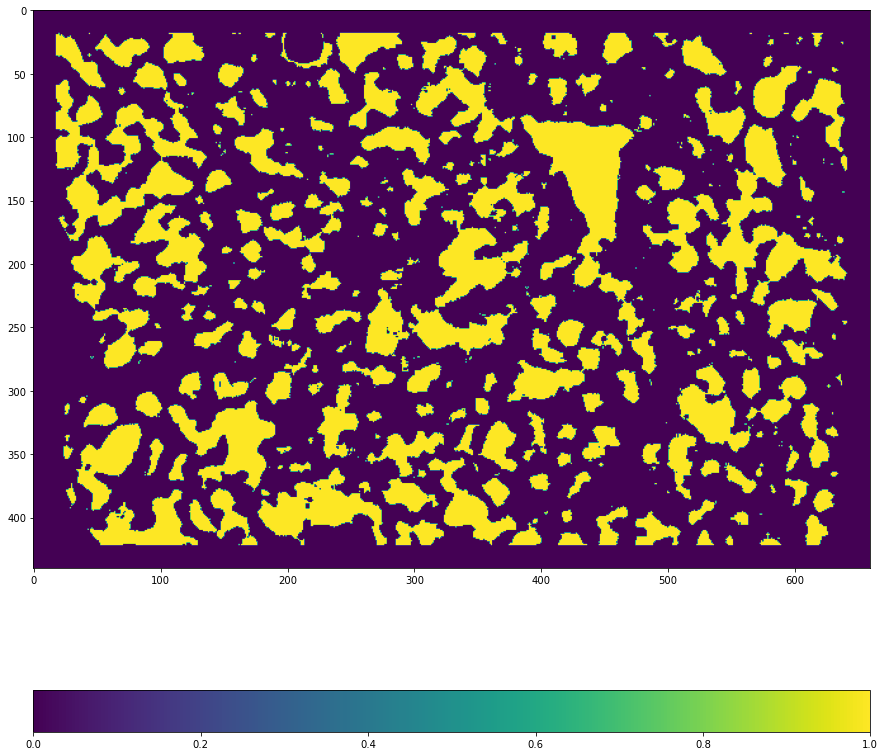

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(pores[:,pores_dtf_r.shape[1]//2,:])
plt.colorbar(orientation='horizontal')
plt.show()

In [24]:
# # #https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
local_maxi = peak_local_max(pores_dtf, indices=False, 
                            threshold_abs=2, min_distance=10,# footprint=np.ones((3, 3, 3)),
                           labels=pores_t)# 
markers, num_features = ndi.label(local_maxi)#, np.ones((3, 3, 3)))
labels = watershed(-pores_dtf, markers, mask=pores_t)

In [25]:
#https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py
# pores_t = pores[200:300, 200:500, 200:500]
# local_maxi = peak_local_max(pores_dtf, indices=False, min_distance=3)#, footprint=np.ones((3, 3, 3)))
# markers, num_features = ndi.label(local_maxi)
# labels = watershed(pores_t, markers)

In [26]:
markers, num_features = ndi.label(labels)
num_features

346

In [27]:
# import os
# def reshape_volume(volume, reshape):
#     res = np.zeros([s//reshape for s in volume.shape], dtype='float32')
#     xs,ys,zs = [s*reshape for s in res.shape]
#     for x,y,z in np.ndindex(reshape, reshape, reshape):
#         res += volume[x:xs:reshape, y:ys:reshape, z:zs:reshape]
#     return res/reshape**3

# def save_amira(in_array, out_path, reshape=3):
#     data_path = str(out_path)
#     with open(os.path.join(data_path, 'amira.raw'), 'wb') as amira_file:
#         reshaped_vol = reshape_volume(in_array, reshape)
#         reshaped_vol.tofile(amira_file)
#         file_shape = reshaped_vol.shape
#         with open(os.path.join(data_path, 'tomo.hx'), 'w') as af:
#                 af.write('# Amira Script\n')
#                 af.write('remove -all\n')
#                 af.write(r'[ load -raw ${SCRIPTDIR}/amira.raw little xfastest float 1 '+
#                          str(file_shape[2])+' '+str(file_shape[1])+' '+str(file_shape[0])+
#                          ' 0 '+str(file_shape[2]-1)+' 0 '+str(file_shape[1]-1)+' 0 '+str(file_shape[0]-1)+
#                          ' ] setLabel tomo.raw\n')

In [28]:
# save_amira(markers, out_dir, 1)

In [29]:
regions=regionprops(markers)

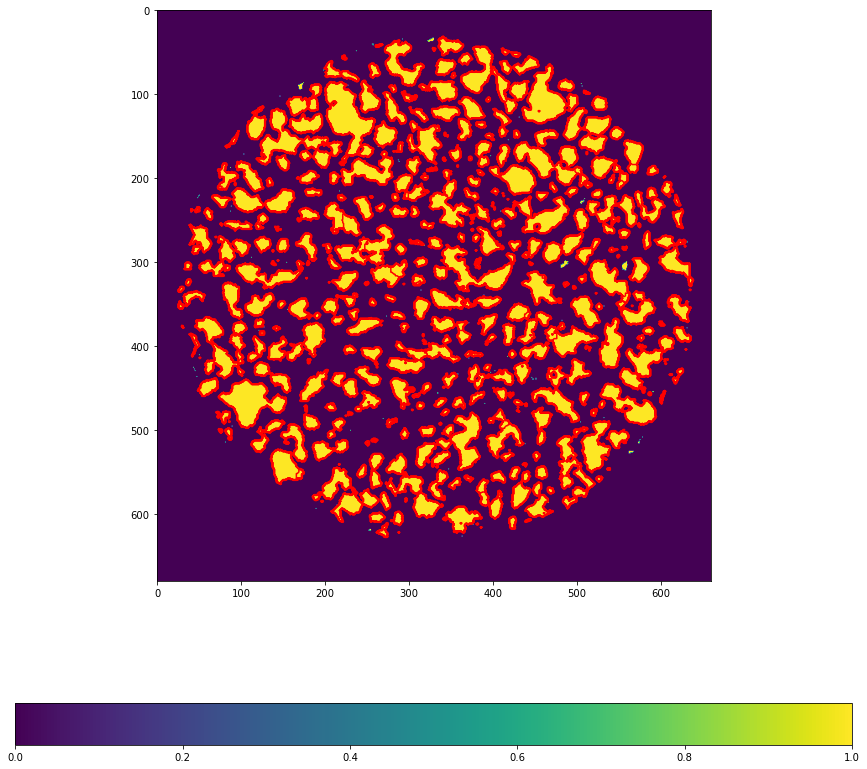

In [30]:
plt.figure(figsize=(15,15))
plt.imshow(pores_t[pores_t.shape[0]//2])
plt.colorbar(orientation='horizontal')
plt.contour(labels[markers.shape[0]//2],colors='r')

plt.show()

In [31]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

Number of labels: 346


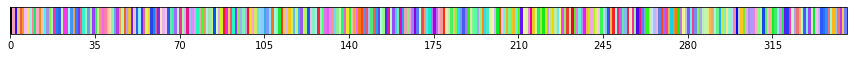

In [32]:
new_cmap = rand_cmap(np.max(markers), type='bright', first_color_black=True, last_color_black=False, verbose=True)

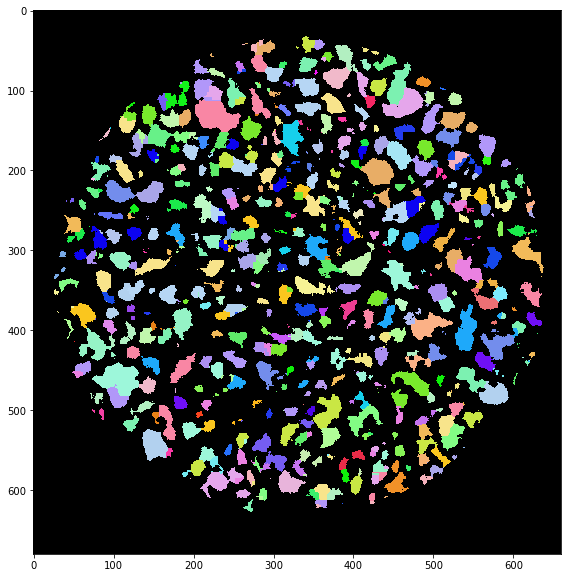

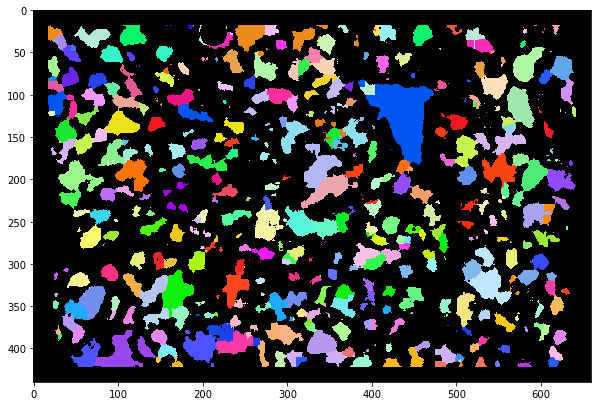

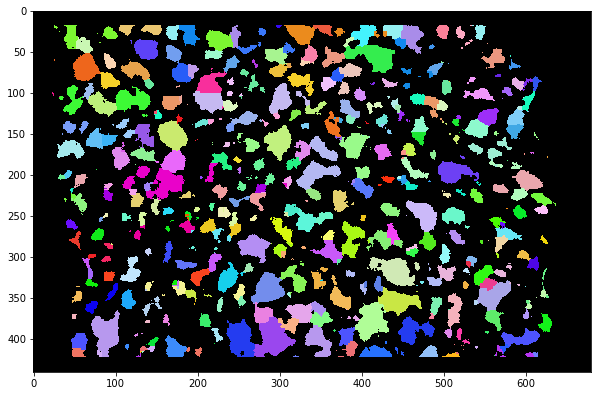

In [33]:
for i in range(3):
    plt.figure(figsize=(10,10))
    
    plt.imshow(labels.take(markers.shape[i]//2, i), cmap=new_cmap, interpolation='nearest')
#     plt.colorbar(orientation='horizontal')
    plt.show()

In [34]:
vol = [r.area for r in regions if r.area>1]
vol = sorted(vol)[:-2]
vol = np.asarray(vol, dtype=np.float32)*(10**3) # pixel size to um
d = np.power(vol/(4.*np.pi/3), 1./3)
# #volume of each pore
# vol = np.zeros((num_features+1), dtype=int)
# for x in tqdm_notebook(labels.flat):
#     vol[x] += 1
print(len(vol))

344


In [35]:
total_vol = np.sum(vol)

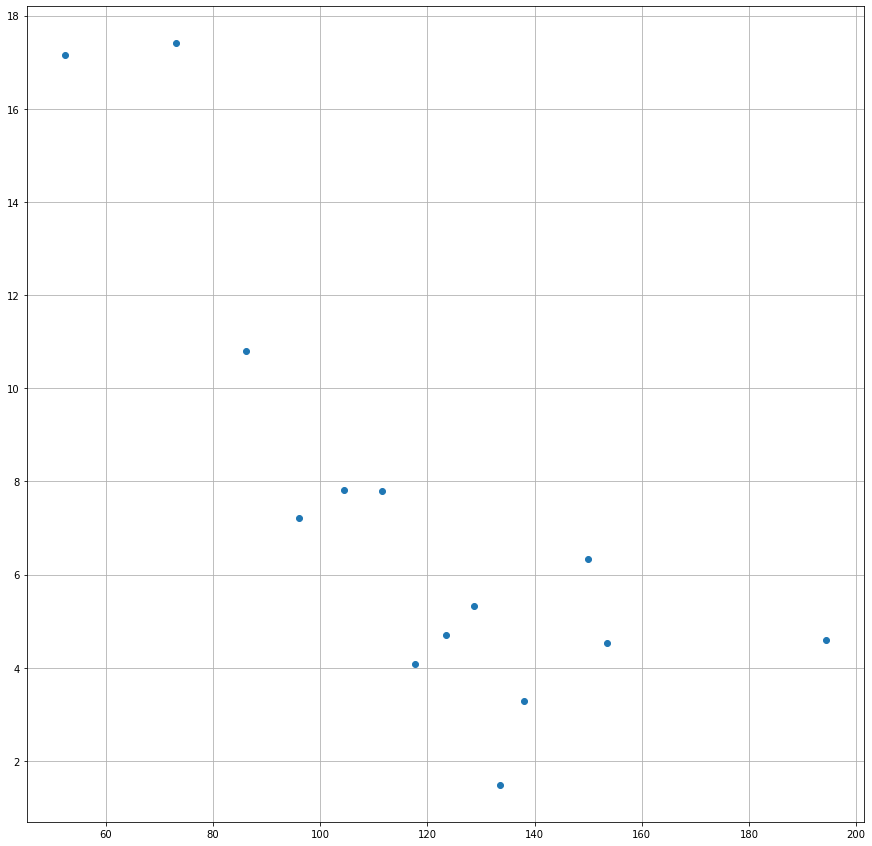

In [36]:
xv, yv = np.histogram(vol[1:], bins=30)
yv = (yv[1:]+yv[:-1])/2.
non_zero = np.argwhere(xv>0)
yv =yv[non_zero]
xv =xv[non_zero]
# xv = xv/np.sum(xv)*100  # to percent

plt.figure(figsize=(15,15))
# plt.plot(yv,xv,'o')
# plt.plot(yv,xv*yv/total_vol*100,'o')
plt.plot(np.power(yv/(4.*np.pi/3), 1./3),xv*yv/total_vol*100,'o')
plt.grid()
plt.show()

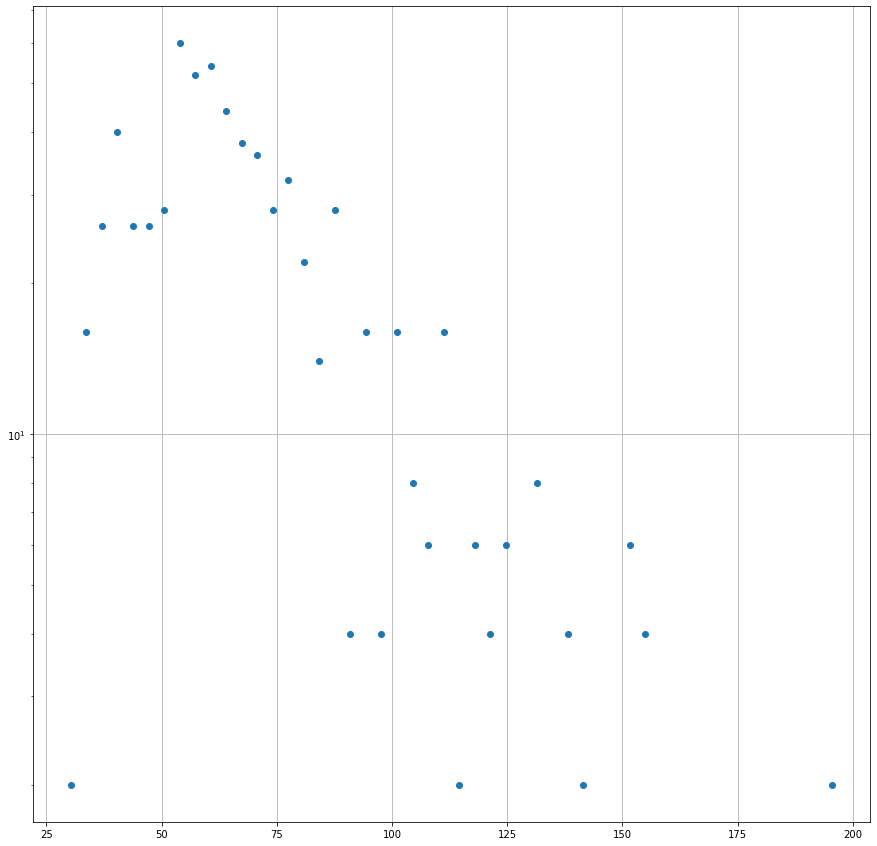

In [37]:
xd, yd = np.histogram(d[1:], bins=50)
xd = xd/len(xd)*100  # to percent
plt.figure(figsize=(15,15))
plt.semilogy(yd[1:],xd,'o')
plt.grid()
plt.show()

In [46]:
np.savez('pores_paper/tomo.npz', xv, yv)

In [38]:
# #Raduis of each pore
# tt = local_maxi*pores_dtf  #todo.fixit
# xr, yr = np.histogram(tt.flat, bins=100)
# xr0, yr0 = np.histogram(np.power(vol,1./3), bins=1000)

In [39]:
# plt.figure(figsize=(15,15))
# plt.semilogy(yr[1:],xr[:],'o')
# plt.semilogy(yr0[2:],xr0[1:],'o')
# plt.xlim([0,20])
# plt.grid()
# plt.show()

# Plot figures

In [ ]:
xz=np.load('pores_paper/tomo.npz')
xv = xz['arr_0']
yv = xz['arr_1']

In [40]:
pores_mur_data = np.loadtxt('pores_paper/3/PDLG_7502_init.vr', skiprows=3)
pores_mur_data = pores_mur_data[200:440] 
pores_mur_data[:,0]*=0.2e-3 #muliply to magic value from vvo and go to um
pores_mur_data[:,1]*=1e4 #muliply to magic value from vvo and go to um

In [41]:
hg_pores = np.loadtxt('pores_paper/4a2.csv')

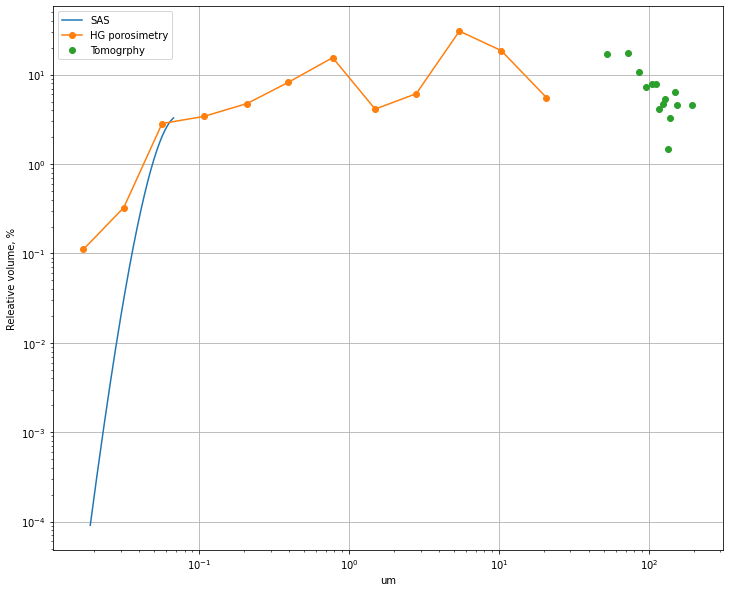

In [58]:
plt.figure(figsize=(12, 10))
plt.loglog(pores_mur_data[:,0],pores_mur_data[:,1]*4./3*np.pi*pores_mur_data[:,0]*5e5, label = 'SAS')
plt.xlabel('um')
plt.loglog(hg_pores[:,0],hg_pores[:,1], '-o', label= 'HG porosimetry')
plt.grid()
plt.loglog(np.power(yv/(4.*np.pi/3), 1./3),xv*yv/total_vol*100, 'o', label='Tomogrphy')
plt.ylabel('Releative volume, %')
plt.legend()

In [56]:
xz=np.load('pores_paper/tomo.npz')
xv = xz['arr_0']
yv = xz['arr_1']

In [57]:
xv

array([[191],
       [ 71],
       [ 27],
       [ 13],
       [ 11],
       [  9],
       [  4],
       [  4],
       [  4],
       [  1],
       [  2],
       [  3],
       [  2],
       [  1]])